In [1]:
from ROOT import *
from PlotUtils import *

gStyle.SetPaintTextFormat("4.1f")

laterals = ["MuonMINOS","MuonResolution","Angle","MuonMinerva","geant4","response"]

def getBand1D(h,name,number):
    if name == "CV":
        hist = TH1D()
        hist = TH1D(h.Clone(h.GetName()+"_CV"))
        return hist
    errorband = MnvVertErrorBand()
    errorband = h.GetVertErrorBand(name)
    hist = TH1D()
    hist = errorband.GetHist(number).Clone(h.GetName()+name+"_%d"%(number))
    return hist

def getBand2D(h,name,number):
    if name == "CV":
        hist = TH2D()
        hist = TH2D(h.Clone(h.GetName()+"_CV"))
        return hist
    errorband = MnvVertErrorBand2D()
    errorband = h.GetVertErrorBand(name)
    hist = TH1D()
    newname = "%s_%s_%s"%(h.GetName(),name,number)
    hist = errorband.GetHist(number).Clone(newname)
    return hist

def makeWeight1D(h,name,number):
    den = TH1D()
    num = TH1D()
    wt = TH1D()
    den = h.GetCVHistoWithStatError()
    num = getBand1D(h,name,number)
    wt = num.Clone(num.GetName()+"_weights")
    wt.Divide(num,den)
    return wt

def makeWeight2D(h,name,number):
    den = TH2D()
    num = TH2D()
    wt = TH2D()
    den = h.GetCVHistoWithStatError()
    num = getBand2D(h,name,number)
    wt = num.Clone(num.GetName()+"_weight")
    wt.Divide(num,den)
    return wt



def drawme1D(h):
    n = "c_"+h.GetName()
    c = TCanvas(n,n)
    h.Draw("PE")
    c.Draw()
    c.Print(n+".jpg")
    return c
    
def drawme2D(h):
    n = "c_"+h.GetName()
    c = TCanvas(n,n)
    h.Draw("COLZ")
    h.Draw("TEXT SAME")
    c.Draw()
    c.Print(n+".jpg")
    return c
    
def deweight(h1, h2):
    hnew = MnvH2D()
    hnew = h2.Clone(h2.GetName()+"_deweight")
    hnew.Reset()
    for x in range(0,h2.GetXaxis().GetNbins()+1):
        for y in range(0,h2.GetYaxis().GetNbins()+1):
            dw = h1.GetBinContent(y)
            if (dw != 0):
                new = h2.GetBinContent(x,y)/dw
                newerr = h2.GetBinError(x,y)/dw
            else:
                new = 1.0
                newerr = 0.0
            #print (x,y, h2.GetBinContent(x,y), dw, new)
            hnew.SetBinContent(x,y,new)
            hnew.SetBinError(x,y,newerr)
    return hnew

def doweight(h1, h2):
    hnew = TH2D()
    hnew = TH2D(h2.Clone(h2.GetName()+"_addweight"))
    hnew.Reset()
    for x in range(0,h2.GetXaxis().GetNbins()+1):
        for y in range(0,h2.GetYaxis().GetNbins()+1):
            dw = h1.GetBinContent(y)
            if (dw != 0):
                new = h2.GetBinContent(x,y)*dw
                
            else:
                new = 1.0
            #print (x,y, h2.GetBinContent(x,y), dw, new)
            hnew.SetBinContent(x,y,new)
            hnew.SetBinError(x,y,0.0)
    return hnew

Warning in <TInterpreter::ReadRootmapFile>: class  PlotUtils::ChainWrapper found in libplotutils.dylib  is already in libMATDict.so 
Warning in <TInterpreter::ReadRootmapFile>: class  PlotUtils::GridCanvas found in libplotutils.dylib  is already in libMATDict.so 
Warning in <TInterpreter::ReadRootmapFile>: class  PlotUtils::MnvH1D found in libplotutils.dylib  is already in libMATDict.so 
Warning in <TInterpreter::ReadRootmapFile>: class  PlotUtils::MnvH2D found in libplotutils.dylib  is already in libMATDict.so 
Warning in <TInterpreter::ReadRootmapFile>: class  PlotUtils::MnvH3D found in libplotutils.dylib  is already in libMATDict.so 
Warning in <TInterpreter::ReadRootmapFile>: class  PlotUtils::MnvLatErrorBand found in libplotutils.dylib  is already in libMATDict.so 
Warning in <TInterpreter::ReadRootmapFile>: class  PlotUtils::MnvLatErrorBand2D found in libplotutils.dylib  is already in libMATDict.so 
Warning in <TInterpreter::ReadRootmapFile>: class  PlotUtils::MnvLatErrorBand3D f

Welcome to JupyROOT 6.24/02


In [2]:
def newband2D(bandin):
   
    bandin = newvert.GetNHists()
     
    for n in range(0,nuniv):
        
        nx= th2.GetXaxis().GetNbins()
        ny= th2.GetYaxis().GetNbins()
        for x in range(0,nx+1):
            for y in range(0,ny+1):
                if x == 2 and y == 2:
                    print ("before",replacement.GetVertErrorBand(name).GetHist(n).GetBinContent(x,y))
                replacement.GetVertErrorBand(name).GetHist(n).SetBinContent(x,y,th2.GetBinContent(x,y))
                if x == 2 and y == 2:
                    print ("after",replacement.GetVertErrorBand(name).GetHist(n).GetBinContent(x,y))
    return replacement
                       

In [3]:
# give back a pseudo response based on the 1-D weights and the CV response

def pseudoResponse(Response):
    hnew = MnvH2D()
    hnew = Response.Clone(Response.GetName()+"_pseudo")
    cvResponse = getBand2D(Response,"CV",0)
    cvsum = TH1D()
    cvsum = cvResponse.ProjectionY()

    bands = Response.GetVertErrorBandNames()
    for name in bands:
        if name in laterals:
            continue
        theband = TH2D()
        theband = hnew.GetVertErrorBand(name)
        nuniv = theband.GetNHists()
        for n in range(0,nuniv):         
            thehist = getBand2D(Response,name,n)
            bandsum = TH1D()
            bandsum = thehist.ProjectionY()
            nx = bandsum.GetXaxis().GetNbins()
            ny = bandsum.GetYaxis().GetNbins()
            for x in range(0,nx+1):
                for y in range(0,ny+1):
                    wt = 0.0
                    if bandsum.GetBinContent(y) != 0:
                        wt = cvsum.GetBinContent(y)/bandsum.GetBinContent(y)
                        thehist.SetBinContent(x,y,thehist.GetBinContent(x,y)*wt)
            place2D(hnew,thehist,name,n)
                       
    return hnew                  
         
            
        
            
#     hwt = TH1D()
#     #hwt = makeWeight1D(hist,name,number)

#     return doweight(hwt,cvResponse)
    

In [4]:
f = TFile.Open("$HOME/Dropbox/BIGMAT/CCQENu/make_hists/CCQENu_minervame5A_MnvTunev2_QElike_Test_1.root")

selt = MnvH1D()
selr = MnvH2D()
selt = f.Get("h___QElike___qelike___Enu___selected_truth_tuned")
selt.Print()

selr = f.Get("h___QElike___qelike___Enu___response_tuned_migration")

bandcv = getBand1D(selt,"CV",0)


band1 = getBand1D(selt,"Flux",1)

band1.Print()

wt = MnvH1D()
wt = band1.Clone(band1.GetName()+"_weight")
wt.Divide(wt,bandcv)

wt.SetMaximum(1.15)
wt.SetMinimum(0.85)

c = drawme1D(wt).Draw()
#c.Draw()


wt.Print()

selr.Print()

wt2 = makeWeight2D(selr,"Flux",1)
wt2.SetMaximum(1.15)
wt2.SetMinimum(0.85)
#wt2.Print("ALL")


cv1d = getBand2D(selr,"CV",0)
band1r = getBand2D(selr,"Flux",1)

TH1.Print Name  = h___QElike___qelike___Enu___selected_truth_tuned, Entries= 54636, Total sum= 45282.9
TH1.Print Name  = h___QElike___qelike___Enu___selected_truth_tunedFlux_1, Entries= 54636, Total sum= 46782.3
TH1.Print Name  = h___QElike___qelike___Enu___selected_truth_tunedFlux_1_weight, Entries= 5234, Total sum= 14.5306
TH1.Print Name  = h___QElike___qelike___Enu___response_tuned_migration, Entries= 54636, Total sum= 45205.8


Info in <TCanvas::Print>: jpg file c_h___QElike___qelike___Enu___selected_truth_tunedFlux_1_weight.jpg has been created


Info in <TCanvas::Print>: jpg file c_h___QElike___qelike___Enu___response_tuned_migration_CV.jpg has been created
Info in <TCanvas::Print>: jpg file c_h___QElike___qelike___Enu___response_tuned_migration_Flux_1.jpg has been created
Info in <TCanvas::Print>: jpg file c_h___QElike___qelike___Enu___response_tuned_migration_Flux_1_weight.jpg has been created
Info in <TCanvas::Print>: jpg file wt3_0_px.jpg has been created
Info in <TCanvas::Print>: jpg file wt3_1_px.jpg has been created
Info in <TCanvas::Print>: jpg file wt3_2_px.jpg has been created
Info in <TCanvas::Print>: jpg file wt3_3_px.jpg has been created
Info in <TCanvas::Print>: jpg file wt3_4_px.jpg has been created
Info in <TCanvas::Print>: jpg file wt3_5_px.jpg has been created
Info in <TCanvas::Print>: jpg file wt3_6_px.jpg has been created
Info in <TCanvas::Print>: jpg file wt3_7_px.jpg has been created
Info in <TCanvas::Print>: jpg file wt3_8_px.jpg has been created
Info in <TCanvas::Print>: jpg file wt3_9_px.jpg has been c

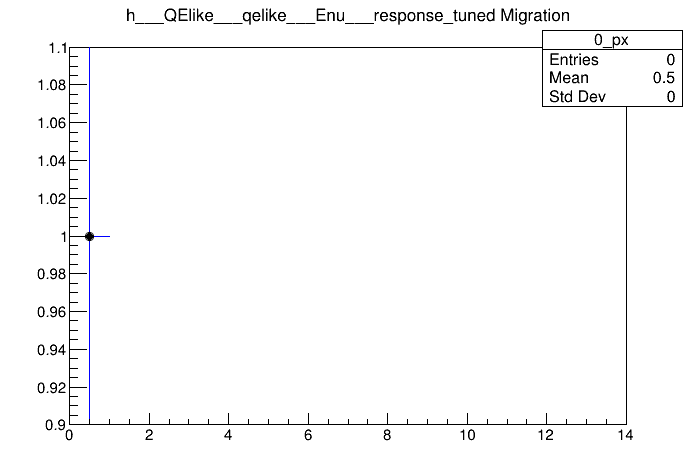

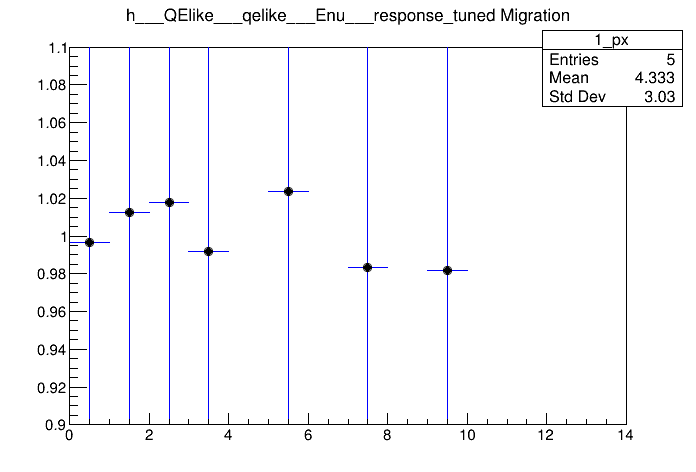

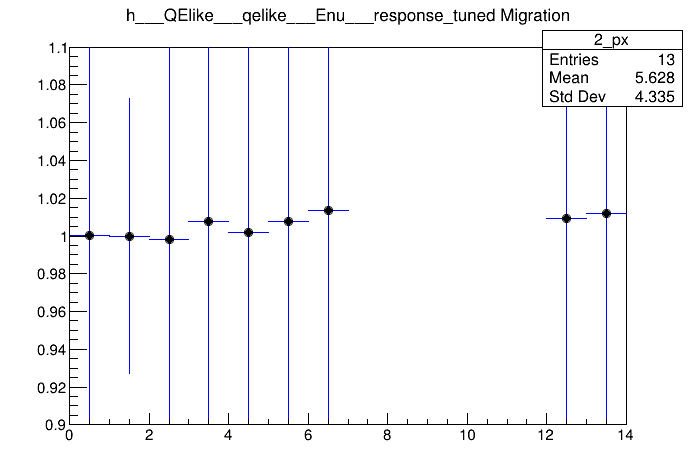

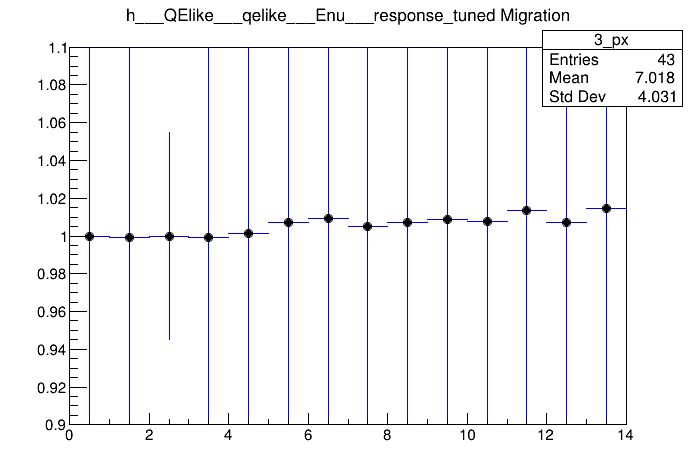

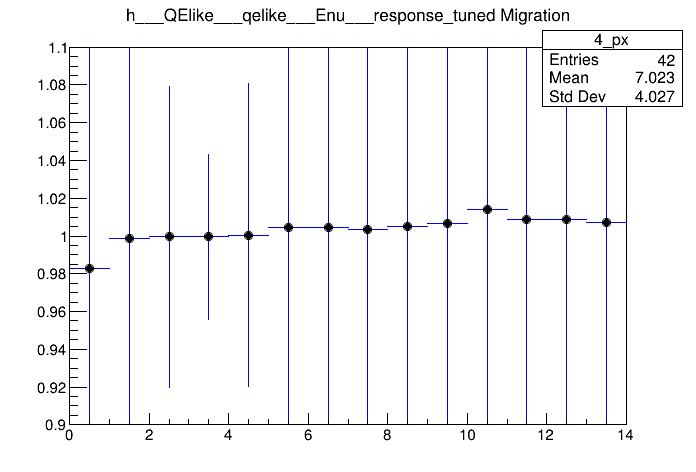

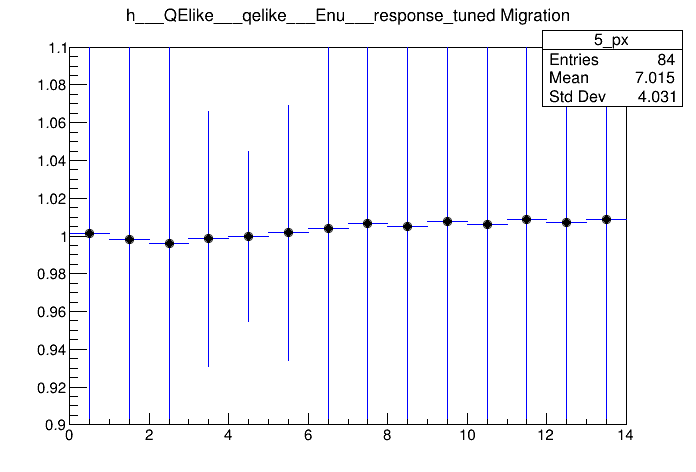

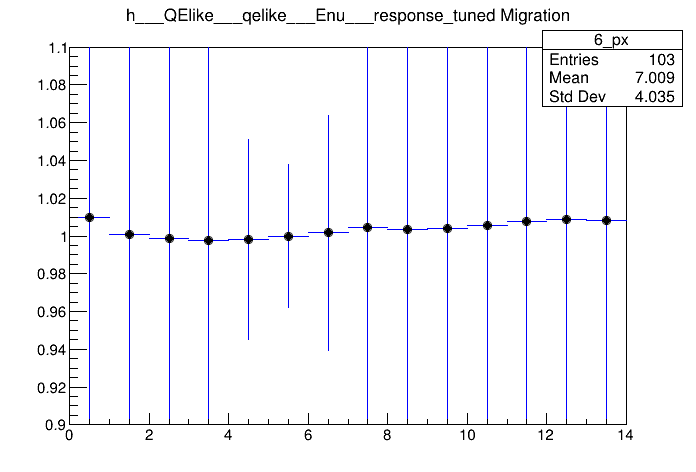

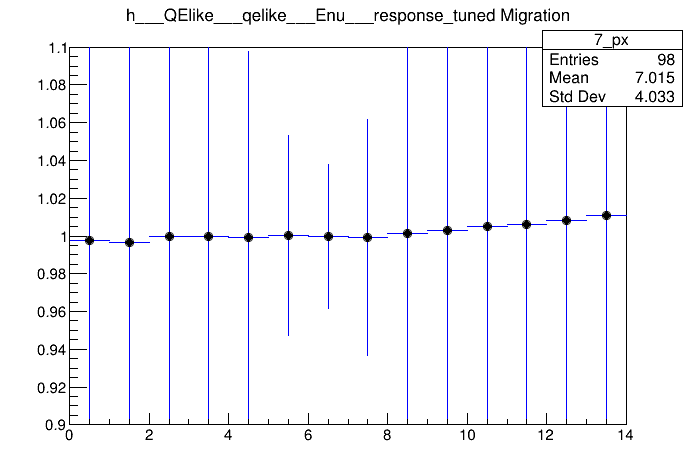

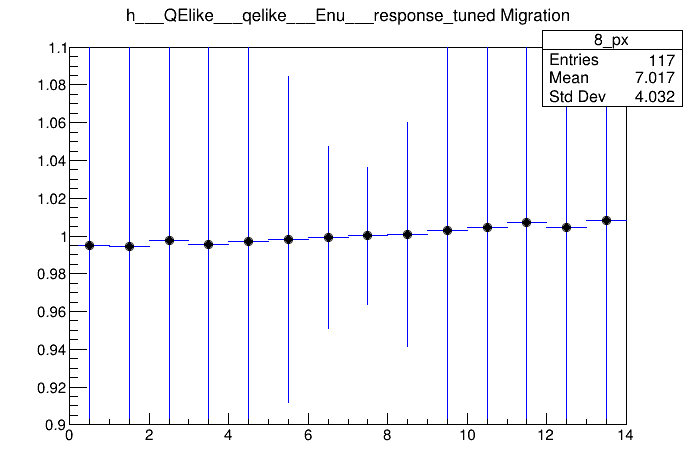

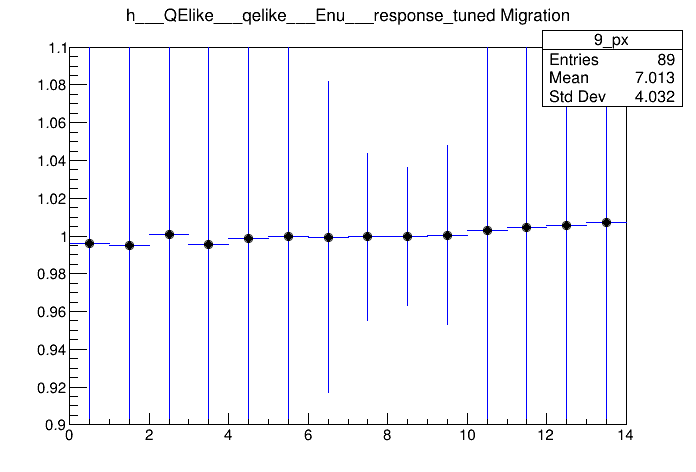

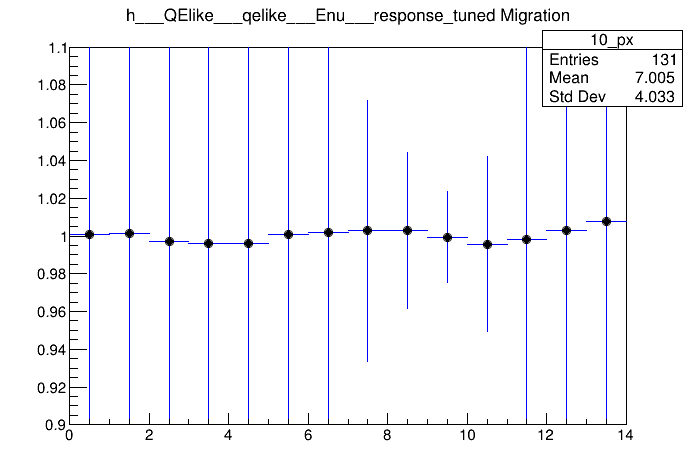

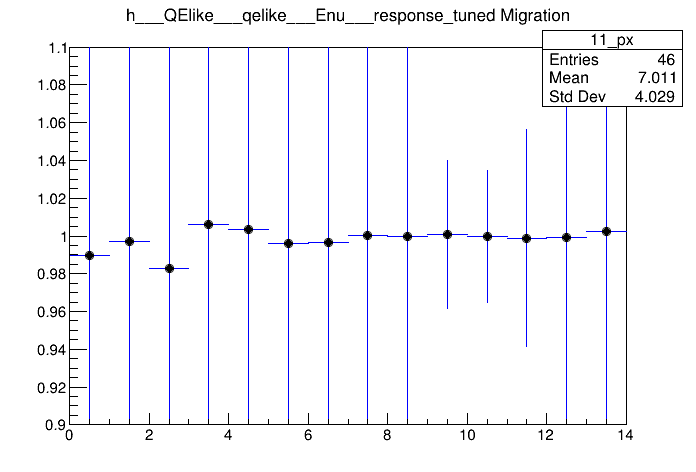

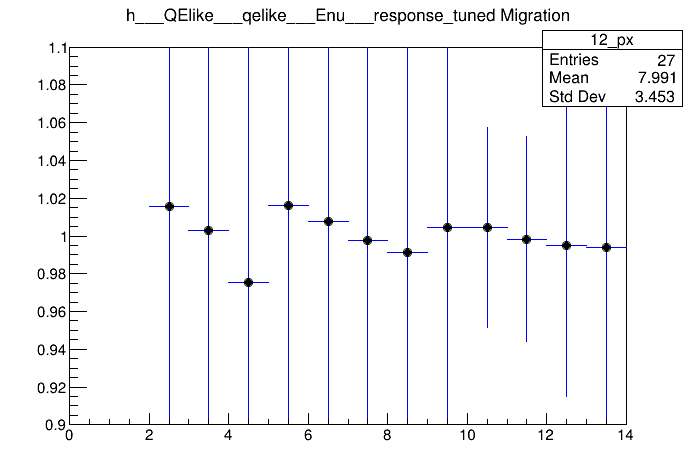

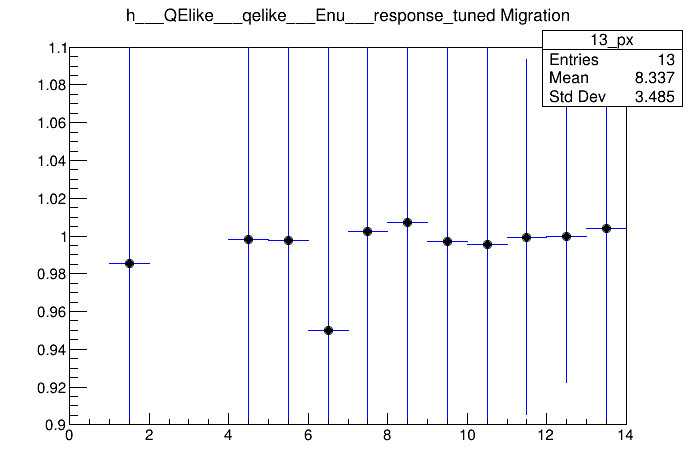

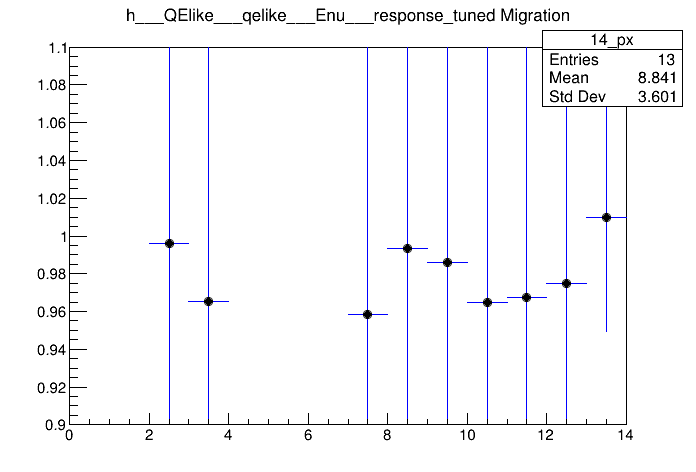

In [5]:
drawme2D(cv1d)
drawme2D(band1r)

gStyle.SetPaintTextFormat("4.4f")

drawme2D(wt2)

wt3=deweight(wt, wt2)

ny = wt3.GetYaxis().GetNbins()

proj = {}
can = {}
for bin in range(0,ny+1):
    proj[bin] = wt3.ProjectionX("%d_px"%bin,bin,bin)
    proj[bin].SetMarkerStyle(20)
    proj[bin].SetMarkerSize(1)
    proj[bin].SetMaximum(1.1)
    proj[bin].SetMinimum(0.9)
    can[bin] = TCanvas("wt3_%d_px"%bin,"w3_%d_px"%bin)
    proj[bin].Draw("pe")
    
    can[bin].Draw()
    can[bin].Print("wt3_%d_px.jpg"%bin)
    

#fake = MnvH2D()
#fake = pseudoResponse(selr)
#drawme2D(fake)

#wt3.Print("ALL")
drawme2D(wt3)

g = TFile.Open("output.root","RECREATE")
wt2.Write()
wt3.Write()
g.Close()